<a href="https://colab.research.google.com/github/Subramanian1990/Deep-Learning/blob/master/RNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
plt.style.use("seaborn")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

#instantiates the device to be used as GPU/CPU 
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device_gpu)

cuda:0


In [6]:

#load the data

languages = []
data = []
X = []
y = []

with open("name2lang.txt", 'r') as f:
    for line in f:
        line = line.split(",")
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

#number of languages
n_languages = len(languages)
print("Total number of languages present: ", n_languages)

Total number of languages present:  18


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

In [8]:
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  16040
The number of observations in the test data:  4010


In [9]:
all_letters = string.ascii_letters + ".,;"
#count the number of letters
n_letters = len(all_letters)

print(n_letters)

55


In [10]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep

In [11]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype = torch.long)

In [12]:
name_rep("kumar")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [13]:
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

In [14]:
def infer(net, name, device = "cpu"):
    name_ohe = name_rep(name).to(device)
    # print(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [15]:

#create hidden layers
n_hidden = 128 #hidden layers count

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_languages).to(device_gpu)

In [16]:

#check for inference
infer(net, "kumar", device_gpu)

tensor([[-2.8186, -2.8863, -2.9395, -2.7844, -2.9499, -2.9481, -2.8592, -2.9096,
         -2.7964, -2.9532, -3.0680, -2.9313, -2.9630, -2.8206, -3.0157, -2.8623,
         -2.7841, -2.7957]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [17]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    
    return to_ret

In [18]:
dataloader(2, X_train, y_train)

[('Arrowsmith',
  'English',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [34]:

def eval(net, n_points, topk, X_, y_, device = "cpu"):
    "Evaluation function"

    net = net.train().to(device_gpu)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:
        name_ohe=name_ohe.to(device)
        lang_rep=lang_rep.to(device)
        #get the output
        # name=name.to(device_gpu)
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
  
    return accuracy

In [38]:
eval(net, 1000, 1, X_test, y_test,device_gpu)

# print


0.487

In [39]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:
        name_ohe=name_ohe.to(device_gpu)
        lang_rep=lang_rep.to(device_gpu)
        hidden = net.init_hidden()
        hidden=hidden.to(device_gpu)
        

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [40]:
net = RNN_net(n_letters, n_hidden, n_languages).to(device_gpu)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [41]:

%%time 
#time for normal training
train(net, opt, criterion, 256)

CPU times: user 1.29 s, sys: 61.4 ms, total: 1.35 s
Wall time: 1.36 s


tensor(2.8888, device='cuda:0', grad_fn=<DivBackward0>)

In [42]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, y_test,device_gpu), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test,device_gpu), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

Iteration 29 Top-1: 0.5092269326683292 Top-2: 0.6795511221945137 Loss 1.731636881828308


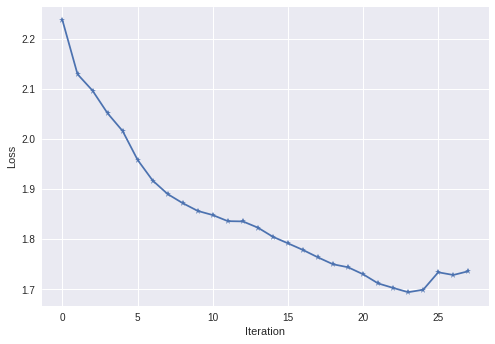

In [ ]:
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)